170498071/170498071 [==============================] - 13s 0us/step


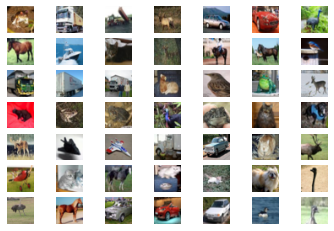

In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
#load image into memory
(trainX,trainy),(testX,testy)=load_data()
for i in range(49):
  pyplot.subplot(7,7,i+1)
  pyplot.axis("off")
  pyplot.imshow(trainX[i])
pyplot.show()

In [2]:
print(trainX.shape)

(50000, 32, 32, 3)


In [3]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np

In [4]:
#define the standalone discriminatormodel
def define_discriminator(in_shape=(32,32,3)):
  model=Sequential()
  #normal
  model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

In [5]:
#define model
model=define_discriminator()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
#function to load the datasetand scale it
#load and prepare cifar10 training images
def load_real_samples():
  (trainX,_),(_,_)=load_data()
  #convert from unsigned ints to floats
  X=trainX.astype('float32')
  #scale from [0,255] to [-1,1]
  X=(X-127.5)/127.5
  return X

In [8]:
X=load_real_samples()
X.shape

(50000, 32, 32, 3)

In [9]:
#select real samples
def generate_real_samples(dataset,n_samples):
  #choose random instances
  ix=np.random.randint(0,dataset.shape[0],n_samples)
  X=dataset[ix]
  y=np.ones((n_samples,1))
  return X,y

In [11]:
X,y=generate_real_samples(X,64)
print(X.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [12]:
#generate n fake samples with class labels
def generate_fake_samples(n_samples):
  #generate uniform random numbers in [0,1]
  X=np.random.rand(32*32*3*n_samples)
  #update to have the range[-1,1]
  X=-1+X*2
  #reshape into batch of color image
  X=X.reshape((n_samples,32,32,3))
  #generate 'fake' class label(0)
  y=np.zeros((n_samples,1))
  return X,y

In [14]:
X,y=generate_fake_samples(64)
print(X.shape)
print(y)

(64, 32, 32, 3)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


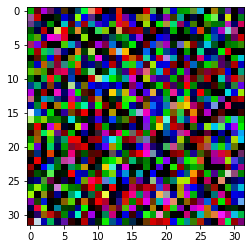

In [15]:
pyplot.imshow(X[0])

In [16]:
#train the discriminator model temporarily
def train_discriminator(model,dataset,n_iter=20,n_batch=128):
  half_batch=int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly selected 'real' samples
    X_real,y_real=generate_real_samples(dataset,half_batch)
    #update discriminator on real samples
    _,real_acc=model.train_on_batch(X_real,y_real)
    #generate fake examples
    X_fake,y_fake=generate_fake_samples(half_batch)
    #update discriminator on fake images
    _,fake_acc=model.train_on_batch(X_fake,y_fake)
    #summarize performance
    print(f'{i}--->{real_acc*100}---->{fake_acc*100}')

In [17]:
# example training 
# define the discriminator model
model=define_discriminator()
#load image data
dataset=load_real_samples()
#fit the model
train_discriminator(model,dataset)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0--->43.75---->0.0
1--->96.875---->7.8125
2--->90.625---->43.75
3--->82.8125---->81.25
4--->87.5---->95.3125
5--->82.8125---->100.0
6--->71.875---->100.0
7--->70.3125---->100.0
8--->85.9375---->100.0
9--->87.5---->100.0
10--->92.1875---->100.0
11--->92.1875---->100.0
12--->96.875---->100.0
13--->98.4375---->100.0
14--->98.4375---->100.0
15--->98.4375---->100.0
16--->100.0---->100.0
17--->98.4375---->100.0
18--->100.0---->100.0
19--->100.0---->100.0


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU


In [19]:

#define the standalone generator model
def define_generator(latent_dim):
  model=Sequential()
  #foundation of 4x4 image
  n_nodes=256*4*4 #just becz we want output image of 32x32x3 so it should be 32x32 or 16x16 or 8x8 ... 4x4 is good for gain
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  #unsample to 8x8
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding=('same')))
  model.add(LeakyReLU(alpha=0.2))
  #unsample to 16x16
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding=('same')))
  model.add(LeakyReLU(alpha=0.2))
  #unsample to 32x32
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding=('same')))
  model.add(LeakyReLU(alpha=0.2))
  #output layer
  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
  return model

In [20]:
#define the size of the latent space
latent_dim=100
model=define_generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [22]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim,n_samples):
  #generate points in the latent space
  x_input=np.random.randn(latent_dim*n_samples)
  #reshapeinto a batch of inputs for the network
  x_input=x_input.reshape(n_samples,latent_dim)
  return x_input

In [23]:
x_input=generate_latent_points(100,64)

In [24]:
x_input.shape

(64, 100)

In [25]:
#use the generator to generate n fake examples ,with class labels
def generate_fake_samples(g_model,latent_dim,n_samples):
  #generate points in latent space
  x_input=generate_latent_points(latent_dim,n_samples)
  #predict output
  X=g_model.predict(x_input)
  #create 'fake class labels 0
  y=np.zeros((n_samples,1))
  return X,y

2/2 [==============================] - 1s 112ms/step


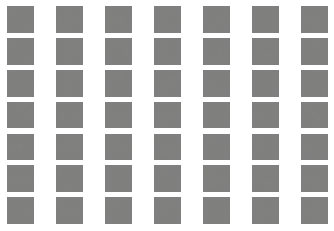

In [26]:
#size of latent space
latent_dim=100
#define the discriminator model
model=define_generator(latent_dim)
#generate samples
n_samples=49
X,_=generate_fake_samples(model,latent_dim,n_samples)
#scale pixcel value to [-1,1] to [0,1]
X=(X+1)/2.0
#plot the generated samples
for i in range(n_samples):
  pyplot.subplot(7,7,i+1)
  pyplot.axis('off')
  pyplot.imshow(X[i])
pyplot.show()

In [27]:
#define the combined generator and discreminator model for updating the generator
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable=False
  #connect them
  model=Sequential()
  #add generator
  model.add(g_model)
  #add discriminator
  model.add(d_model)
  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [28]:
#size of the latent space
latent_dim=100
#create the discrimantor
d_model=define_discriminator()
#create generator
g_model=define_generator(latent_dim)
gan_model=define_gan(g_model,d_model)
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [29]:
#train the generator and discriminator
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=200,n_batch=128):
  bat_per_epo=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  #manually enumerate epochs
  for i in range (n_epochs):
    for j in range(bat_per_epo):
      #get randomly selectd 'real' samples
      X_real,y_real=generate_real_samples(dataset,half_batch)
      #uupdate discriminator model weights
      d_loss1,_=d_model.train_on_batch(X_real,y_real)
      #generate 'fake' examples
      X_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)
      #discriminator model weight update
      d_loss2,_=d_model.train_on_batch(X_fake,y_fake)
      #prepare points in latent space as input for the generator
      X_gan=generate_latent_points(latent_dim,n_batch)
      #create inverted labels for fake samples
      y_gan=np.ones((n_batch,1))
      #update the generator via discriminator's error
      g_loss=gan_model.train_on_batch(X_gan,y_gan)
      print(f'{i+1},{j+1},{bat_per_epo}, {d_loss1}, {d_loss2} ,{g_loss}')
    if (i+1)%10==0:
      summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [30]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150):
  #prepare real samples
  X_real,y_real=generate_real_samples(dataset,n_samples)
  #evaluate discriminator on real examples
  _,acc_real=d_model.evaluate(X_real,y_real,verbose=0)
  #prepare fake model
  X_fake,y_fake=generate_fake_samples(g_model,latent_dim,n_samples)
  #evaluate discriminator on fake images
  _,acc_fake=d_model.evaluate(X_fake,y_fake,verbose=0)
  #summarize discriminator performance
  print(f"accuracy real: {acc_real*100},{acc_fake*100}")
  save_plot(X_fake,epoch)
  filename="generator_model_%03d.h5"%(epoch+1)
  g_model.save(filename)



In [31]:
def save_plot(examples,epoch,n=7):
  #scale from [-1,1] to [0,1]
  examples=(examples+1)/2.0
  #plot image
  for i in range(n*n):
    pyplot.subplot(n,n,i+1)
    pyplot.axis('off')
    pyplot.imshow(examples[i])
  filename='generated_plot_e%03d.png' %(epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

In [32]:
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=500,n_batch=128)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 16ms/step
4,232,390, 0.76899653673172, 0.6581205129623413 ,1.0778108835220337
2/2 [==============================] - 0s 7ms/step
4,233,390, 0.7239633202552795, 0.6125854253768921 ,1.0542948246002197
2/2 [==============================] - 0s 5ms/step
4,234,390, 0.7549746036529541, 0.6722457408905029 ,0.9881258010864258
2/2 [==============================] - 0s 6ms/step
4,235,390, 0.6171262264251709, 0.6184127926826477 ,1.0451114177703857
2/2 [==============================] - 0s 4ms/step
4,236,390, 0.5432478785514832, 0.6828125715255737 ,1.0753118991851807
2/2 [==============================] - 0s 4ms/step
4,237,390, 0.5309474468231201, 0.6006819009780884 ,1.056242823600769
2/2 [==============================] - 0s 5ms/step
4,238,390, 0.5906994342803955, 0.6153457164764404 ,1.0629392862319946
2/2 [==============================] - 0s 11ms/step
4,239,390, 0.5503439903259277, 0.6277938485145569 ,1

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 15ms/step
14,232,390, 0.6260585784912109, 0.6097465753555298 ,0.8446330428123474
2/2 [==============================] - 0s 4ms/step
14,233,390, 0.618323802947998, 0.6262685656547546 ,0.8546561598777771
2/2 [==============================] - 0s 5ms/step
14,234,390, 0.622025728225708, 0.65636146068573 ,0.85115647315979
2/2 [==============================] - 0s 5ms/step
14,235,390, 0.6697428226470947, 0.6599088311195374 ,0.9249633550643921
2/2 [==============================] - 0s 10ms/step
14,236,390, 0.6518102884292603, 0.6388483047485352 ,0.9209455251693726
2/2 [==============================] - 0s 4ms/step
14,237,390, 0.6317007541656494, 0.6122638583183289 ,1.0140334367752075
2/2 [==============================] - 0s 6ms/step
14,238,390, 0.7132452130317688, 0.5609396696090698 ,1.0317966938018799
2/2 [==============================] - 0s 6ms/step
14,239,390, 0.7444128394126892, 0.50944745540618

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
24,232,390, 0.7108439207077026, 0.6650055646896362 ,0.8041576147079468
2/2 [==============================] - 0s 10ms/step
24,233,390, 0.6273974180221558, 0.6766671538352966 ,0.8007594347000122
2/2 [==============================] - 0s 7ms/step
24,234,390, 0.6322473287582397, 0.696963906288147 ,0.8184252977371216
2/2 [==============================] - 0s 12ms/step
24,235,390, 0.6295002698898315, 0.6828767657279968 ,0.8338950872421265
2/2 [==============================] - 0s 9ms/step
24,236,390, 0.7211081981658936, 0.6507383584976196 ,0.7961597442626953
2/2 [==============================] - 0s 5ms/step
24,237,390, 0.6194483041763306, 0.7234976291656494 ,0.8324732780456543
2/2 [==============================] - 0s 11ms/step
24,238,390, 0.6536070108413696, 0.6732800006866455 ,0.8124810457229614
2/2 [==============================] - 0s 12ms/step
24,239,390, 0.6130749583244324, 0.6813013

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
34,232,390, 0.6582654714584351, 0.6948144435882568 ,0.7860019207000732
2/2 [==============================] - 0s 8ms/step
34,233,390, 0.6829192042350769, 0.6553813815116882 ,0.8556939959526062
2/2 [==============================] - 0s 7ms/step
34,234,390, 0.676232099533081, 0.6227134466171265 ,0.8523538112640381
2/2 [==============================] - 0s 15ms/step
34,235,390, 0.6411593556404114, 0.6451663374900818 ,0.8304159641265869
2/2 [==============================] - 0s 4ms/step
34,236,390, 0.6490325927734375, 0.6469274759292603 ,0.8171278834342957
2/2 [==============================] - 0s 13ms/step
34,237,390, 0.6902590394020081, 0.6316254138946533 ,0.8011482954025269
2/2 [==============================] - 0s 9ms/step
34,238,390, 0.6455894708633423, 0.6520713567733765 ,0.804869532585144
2/2 [==============================] - 0s 8ms/step
34,239,390, 0.6290701627731323, 0.6522956490

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
44,232,390, 0.671525239944458, 0.650700569152832 ,0.8451588153839111
2/2 [==============================] - 0s 6ms/step
44,233,390, 0.6863222718238831, 0.6265102028846741 ,0.810876727104187
2/2 [==============================] - 0s 6ms/step
44,234,390, 0.6194329857826233, 0.6570203900337219 ,0.818818211555481
2/2 [==============================] - 0s 12ms/step
44,235,390, 0.6683464050292969, 0.6922024488449097 ,0.8320675492286682
2/2 [==============================] - 0s 4ms/step
44,236,390, 0.6007898449897766, 0.71901535987854 ,0.8157726526260376
2/2 [==============================] - 0s 13ms/step
44,237,390, 0.646324634552002, 0.6701114177703857 ,0.8087140321731567
2/2 [==============================] - 0s 6ms/step
44,238,390, 0.6601506471633911, 0.6471558809280396 ,0.825681746006012
2/2 [==============================] - 0s 10ms/step
44,239,390, 0.6303812265396118, 0.642247319221496

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 8ms/step
54,232,390, 0.6292353272438049, 0.6337679624557495 ,0.8352534770965576
2/2 [==============================] - 0s 6ms/step
54,233,390, 0.628793478012085, 0.7067263126373291 ,0.8378422260284424
2/2 [==============================] - 0s 7ms/step
54,234,390, 0.6385369896888733, 0.6531859636306763 ,0.8711776733398438
2/2 [==============================] - 0s 13ms/step
54,235,390, 0.642818808555603, 0.6423684358596802 ,0.8779615163803101
2/2 [==============================] - 0s 4ms/step
54,236,390, 0.6229658126831055, 0.6482842564582825 ,0.9327088594436646
2/2 [==============================] - 0s 5ms/step
54,237,390, 0.6837921142578125, 0.5825377702713013 ,0.942457377910614
2/2 [==============================] - 0s 12ms/step
54,238,390, 0.6985793709754944, 0.6233738660812378 ,0.897917628288269
2/2 [==============================] - 0s 6ms/step
54,239,390, 0.7790910005569458, 0.630378425121

2/2 [==============================] - 0s 4ms/step
61,1,390, 0.6717904806137085, 0.6243243217468262 ,0.8669558763504028
2/2 [==============================] - 0s 16ms/step
61,2,390, 0.6624739170074463, 0.609825074672699 ,0.8502026796340942
2/2 [==============================] - 0s 13ms/step
61,3,390, 0.6862071752548218, 0.6800863742828369 ,0.8628655076026917
2/2 [==============================] - 0s 7ms/step
61,4,390, 0.6277657151222229, 0.6899895668029785 ,0.8666486740112305
2/2 [==============================] - 0s 4ms/step
61,5,390, 0.6152431964874268, 0.6202384233474731 ,0.8630467653274536
2/2 [==============================] - 0s 5ms/step
61,6,390, 0.6680574417114258, 0.6752995252609253 ,0.8849154710769653
2/2 [==============================] - 0s 15ms/step
61,7,390, 0.6725324988365173, 0.6630964279174805 ,0.8894147872924805
2/2 [==============================] - 0s 9ms/step
61,8,390, 0.6611298322677612, 0.6315478682518005 ,0.8480778932571411
2/2 [==============================] -

KeyboardInterrupt: ignored